<a href="https://colab.research.google.com/github/MarianoChic09/MSc-AI-taller-de-deep-learning/blob/main/MSc_AI_TDL_Tarea_2_NLP_insincere_questions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
! cp -r "/content/drive/MyDrive/Colab Notebooks/Datasets/insincere_questions/." .
# ! unzip -q insincere_questions.zip
# ! rm insincere_questions.zip
! ls


drive  insincere_questions  sample_data  test_set.csv  train_set.csv


In [16]:
import time
import torch
import itertools
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns


# Carga de datos

In [30]:
# Global device config
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
all_train_data = pd.read_csv("train_set.csv")
train, validation = train_test_split(all_train_data,
stratify=all_train_data.target, test_size=0.2)
print(f"{len(train)} Training questions, {len(validation)} Validation questions")

test = pd.read_csv("test_set.csv")


258592 Training questions, 64648 Validation questions


# Análisis exploratorio

In [31]:
# Análisis exploratorio básico de los datasets
datasets = {'Training': train, 'Validation': validation, 'Test': test}


Información básica del dataset Training:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 258592 entries, 249910 to 212403
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   question_text  258592 non-null  object
 1   target         258592 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 5.9+ MB
None

Primeras 5 filas del dataset Training:
                                            question_text  target
249910  On YouTube, are you allowed to make 20-30 or m...       0
153574  If humans have wings what they doing in daily ...       0
64662   How much value does CodeChef Certified Data St...       0
29304                        What is your favorite track?       0
286064  How does the speed of delivery to the brain af...       0


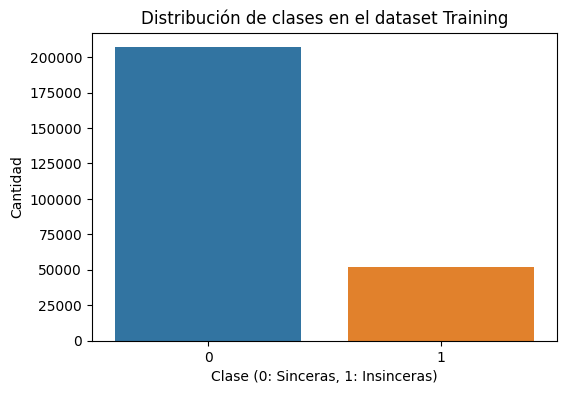

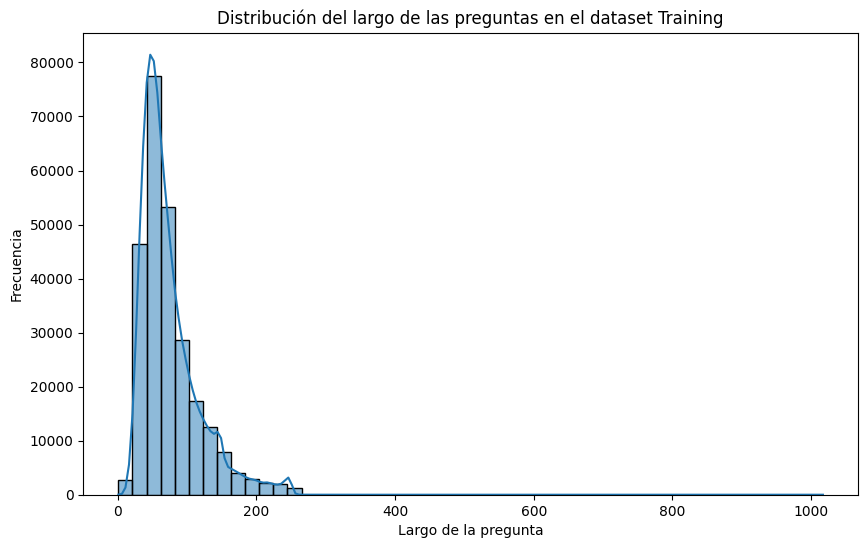

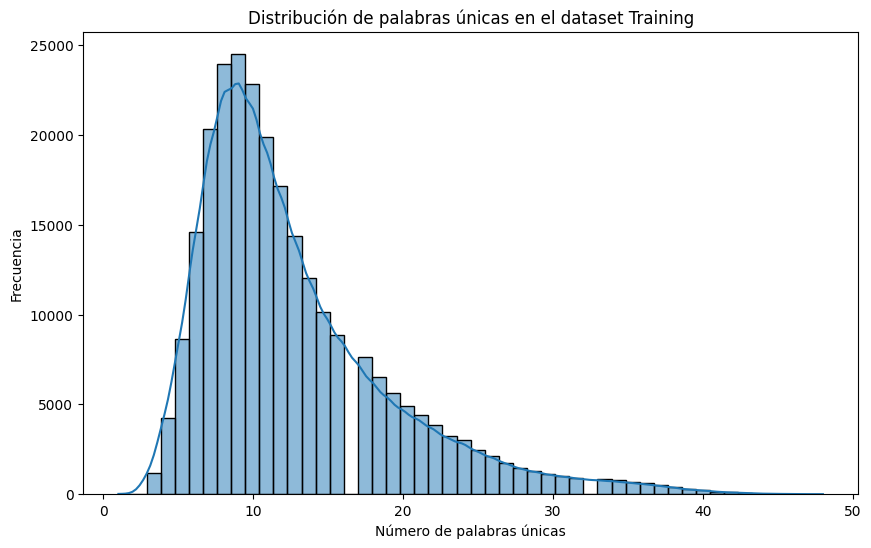


Valores nulos en el dataset Training:
question_text    0
target           0
length           0
unique_words     0
dtype: int64

Información básica del dataset Validation:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 64648 entries, 271282 to 259632
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   question_text  64648 non-null  object
 1   target         64648 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB
None

Primeras 5 filas del dataset Validation:
                                            question_text  target
271282  What are some common mistakes of beginning Dun...       0
279753  Why do some Americans see themselves as the lu...       1
293152  How do I choose the width in a bloom filter im...       0
234564  What are some of the best horror prompts for g...       0
315090   Can you still be an hourglass with a small bust?       0


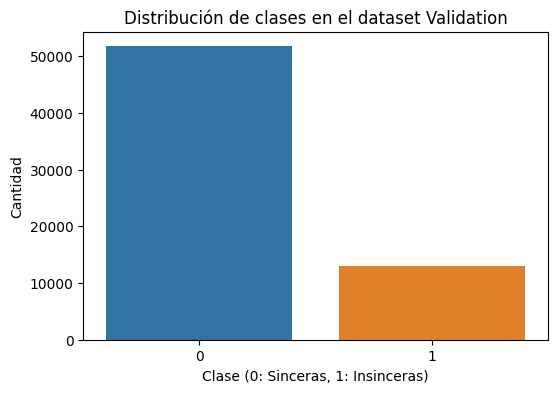

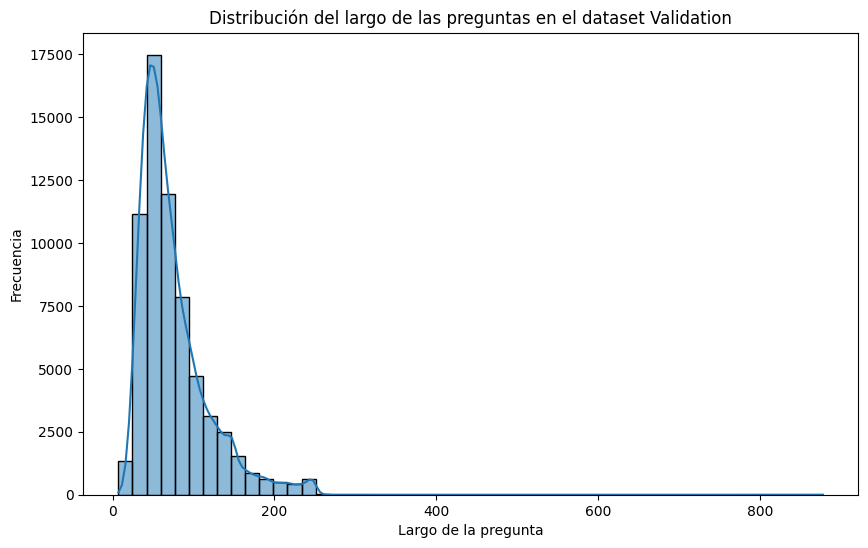

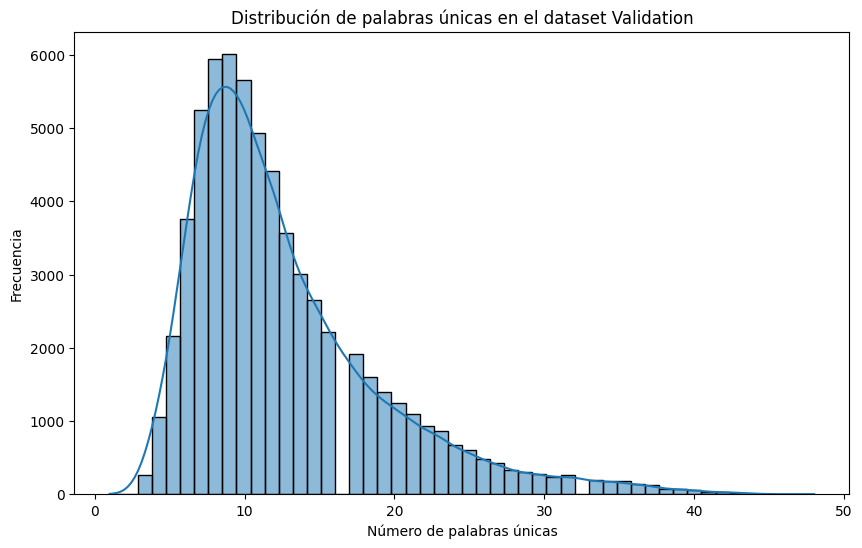


Valores nulos en el dataset Validation:
question_text    0
target           0
length           0
unique_words     0
dtype: int64

Información básica del dataset Test:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80810 entries, 0 to 80809
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   question_text  80810 non-null  object
 1   target         80810 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ MB
None

Primeras 5 filas del dataset Test:
                                       question_text  target
0  Is it weird that I want my future boyfriend to...       0
1               How can I promote my webinar on RPA?       0
2  Why is it Indians in West accept transgenders ...       1
3  How many of these 'Trump achievements' are cor...       0
4  Why did I walk in on my sister fucking my hams...       1


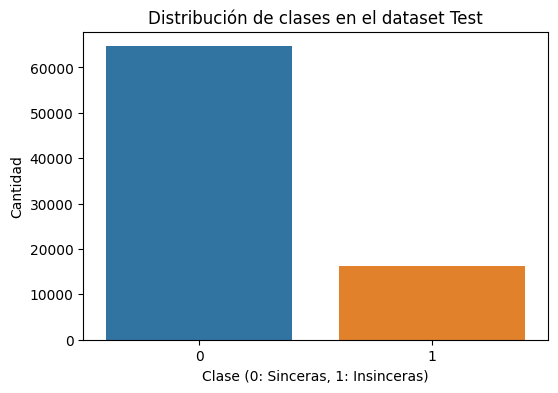

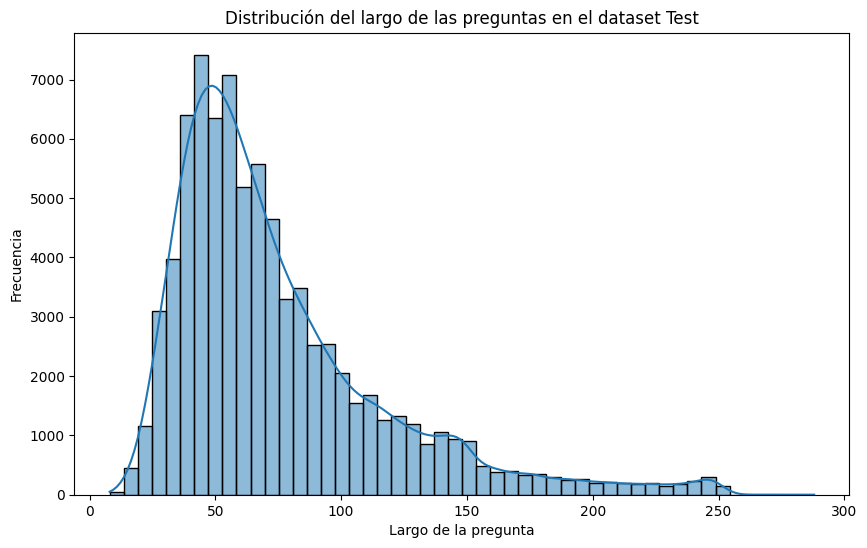

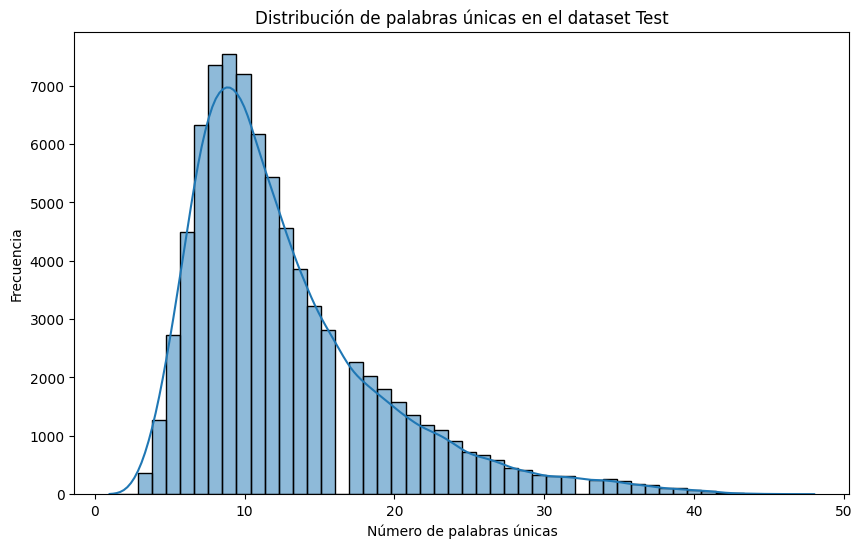


Valores nulos en el dataset Test:
question_text    0
target           0
length           0
unique_words     0
dtype: int64


In [33]:
for name, dataset in datasets.items():
    print(f"\nInformación básica del dataset {name}:")
    print(dataset.info())
    print(f"\nPrimeras 5 filas del dataset {name}:")
    print(dataset.head())

    # Distribución de las clases en el dataset
    if 'target' in dataset.columns:
        plt.figure(figsize=(6, 4))
        sns.countplot(x='target', data=dataset)
        plt.title(f'Distribución de clases en el dataset {name}')
        plt.xlabel('Clase (0: Sinceras, 1: Insinceras)')
        plt.ylabel('Cantidad')
        plt.show()

    # Análisis del largo de las preguntas
    dataset['length'] = dataset['question_text'].apply(len)
    plt.figure(figsize=(10, 6))
    sns.histplot(dataset['length'], bins=50, kde=True)
    plt.title(f'Distribución del largo de las preguntas en el dataset {name}')
    plt.xlabel('Largo de la pregunta')
    plt.ylabel('Frecuencia')
    plt.show()

    # Distribución de palabras únicas
    dataset['unique_words'] = dataset['question_text'].apply(lambda x: len(set(str(x).split())))
    plt.figure(figsize=(10, 6))
    sns.histplot(dataset['unique_words'], bins=50, kde=True)
    plt.title(f'Distribución de palabras únicas en el dataset {name}')
    plt.xlabel('Número de palabras únicas')
    plt.ylabel('Frecuencia')
    plt.show()

    # Verificando valores nulos
    print(f"\nValores nulos en el dataset {name}:")
    print(dataset.isnull().sum())

Las distribuciones entre training, validation y test son muy similares lo cual es un buen indicio.

## Analisis Exploratorio mas avanzado

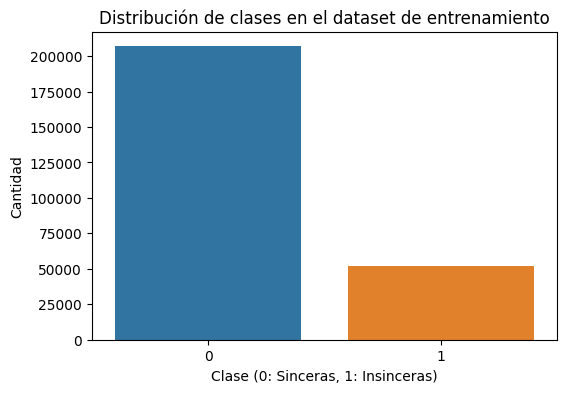

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

# 1. Distribución de clases
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=train)
plt.title('Distribución de clases en el dataset de entrenamiento')
plt.xlabel('Clase (0: Sinceras, 1: Insinceras)')
plt.ylabel('Cantidad')
plt.show()

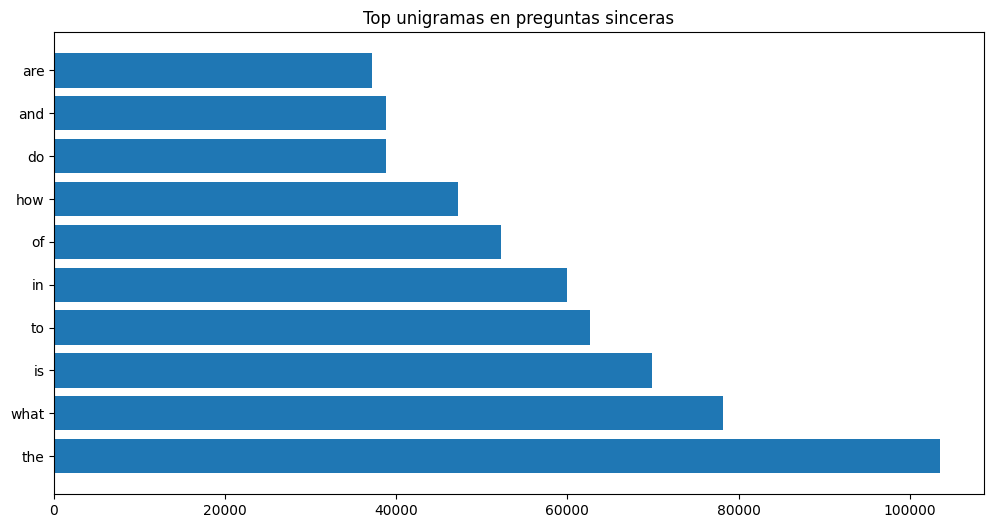

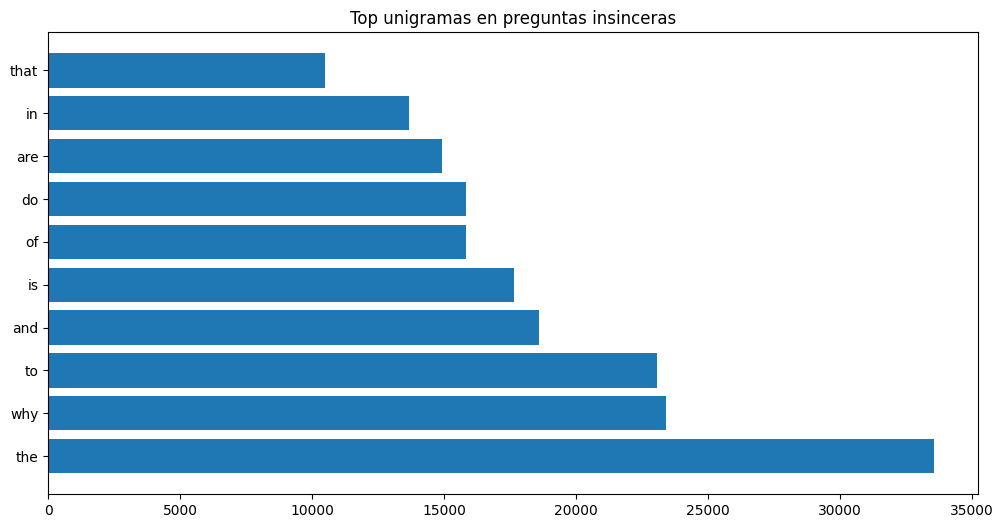

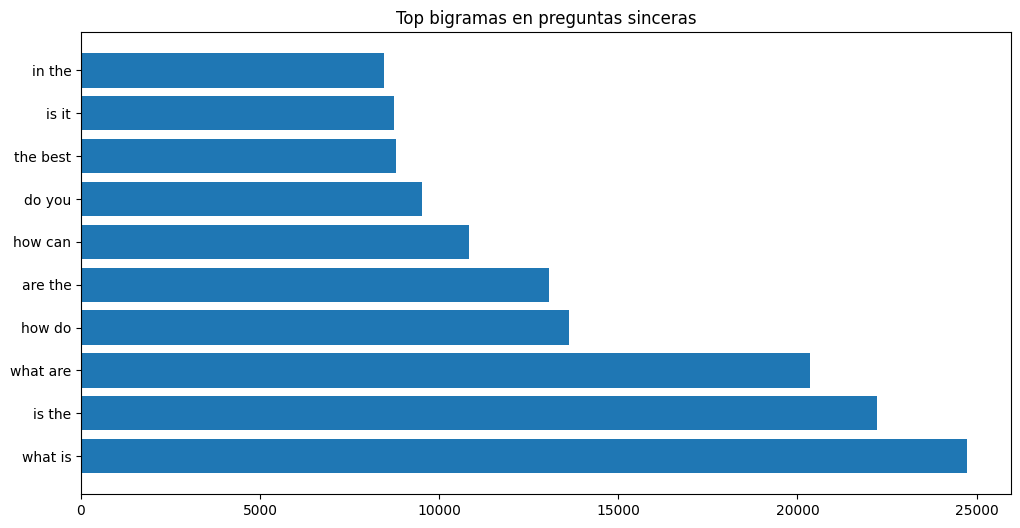

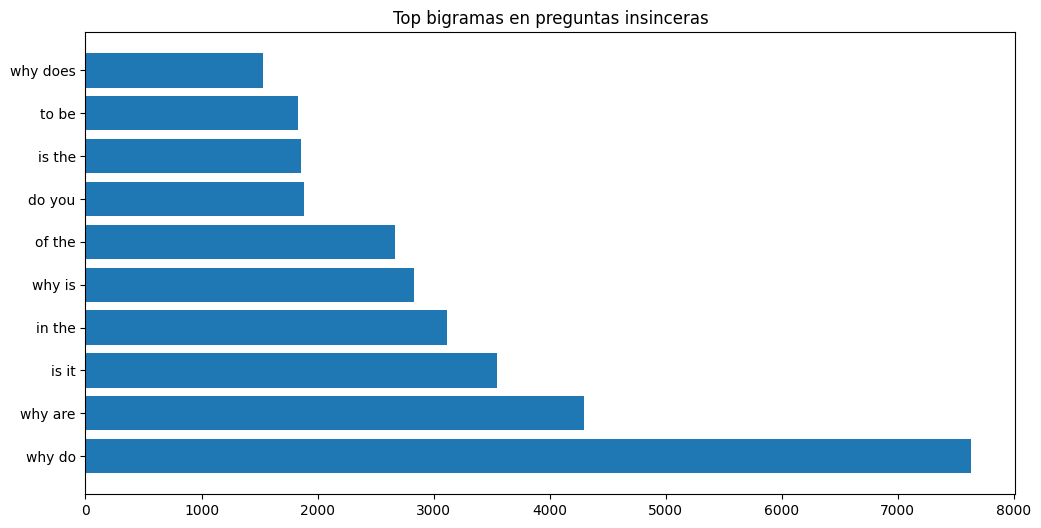

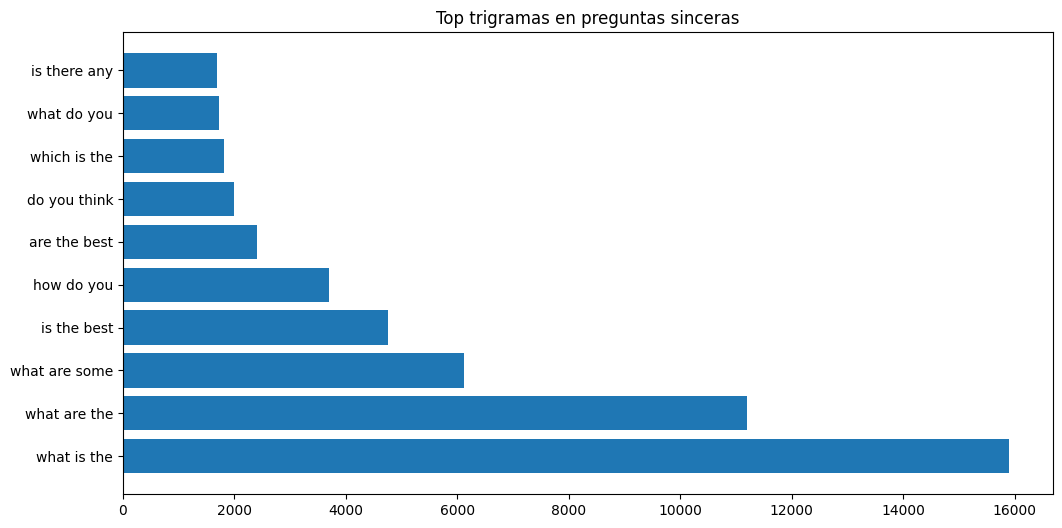

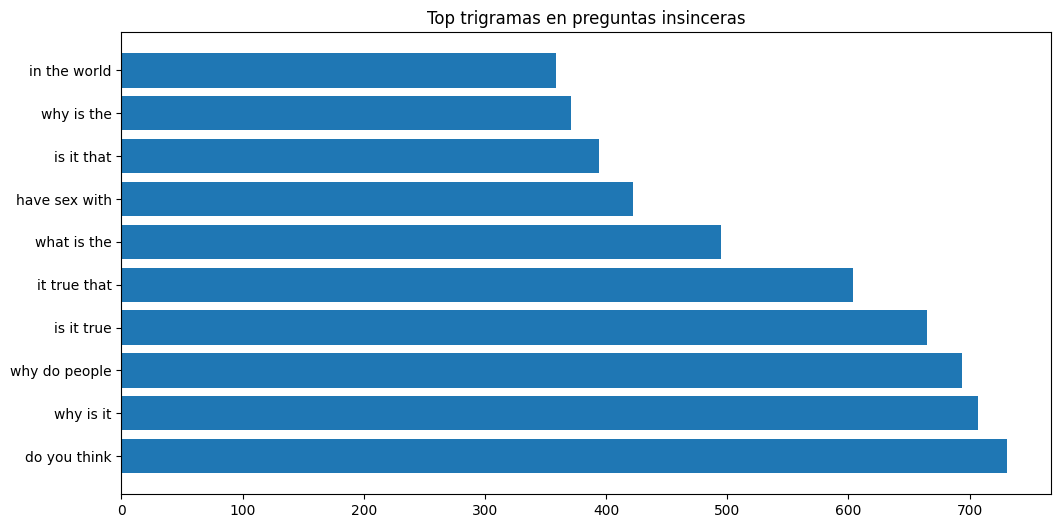

In [41]:
# 2. Análisis de n-gramas
def plot_top_ngrams(data, ngram_range=(1,1), top=10, title=""):
    # Función para plotear los n-gramas más comunes
    vec = CountVectorizer(ngram_range=ngram_range).fit(data)
    bag_of_words = vec.transform(data)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    words, values = zip(*words_freq[:top])
    plt.figure(figsize=(12, 6))
    plt.barh(words, values)
    plt.title(title)
    plt.show()

plot_top_ngrams(train[train['target']==0]['question_text'], (1,1), title="Top unigramas en preguntas sinceras")
plot_top_ngrams(train[train['target']==1]['question_text'], (1,1), title="Top unigramas en preguntas insinceras")
plot_top_ngrams(train[train['target']==0]['question_text'], (2,2), title="Top bigramas en preguntas sinceras")
plot_top_ngrams(train[train['target']==1]['question_text'], (2,2), title="Top bigramas en preguntas insinceras")
plot_top_ngrams(train[train['target']==0]['question_text'], (3,3), title="Top trigramas en preguntas sinceras")
plot_top_ngrams(train[train['target']==1]['question_text'], (3,3), title="Top trigramas en preguntas insinceras")

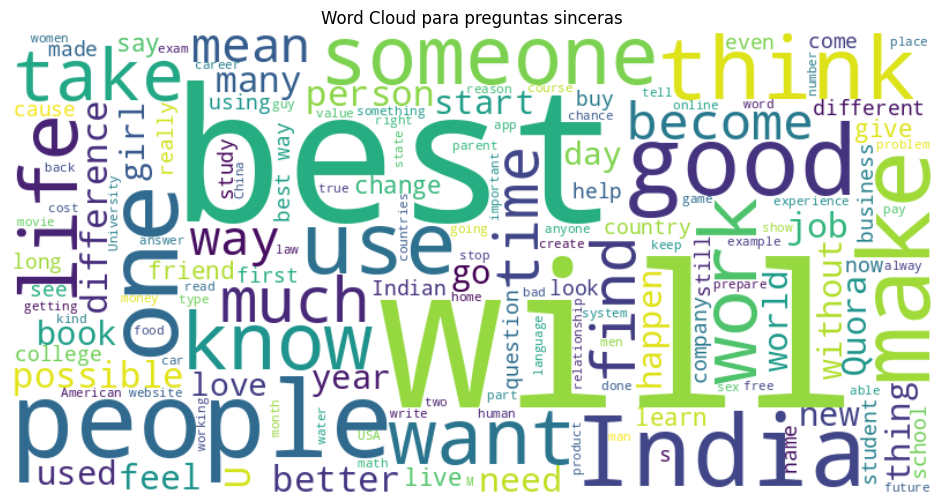

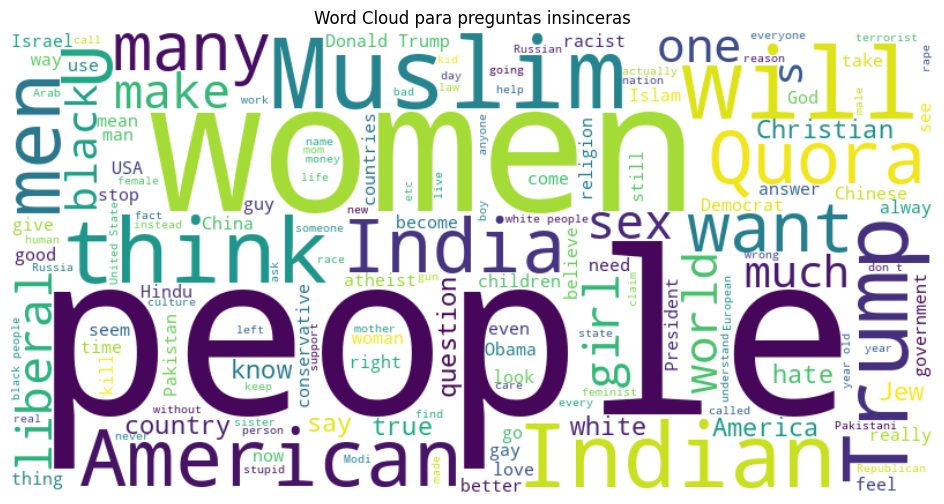

In [42]:
# 3. Word Clouds
def plot_wordcloud(data, title=""):
    # Función para plotear una nube de palabras
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=150).generate(" ".join(data))
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

plot_wordcloud(train[train['target']==0]['question_text'], "Word Cloud para preguntas sinceras")
plot_wordcloud(train[train['target']==1]['question_text'], "Word Cloud para preguntas insinceras")




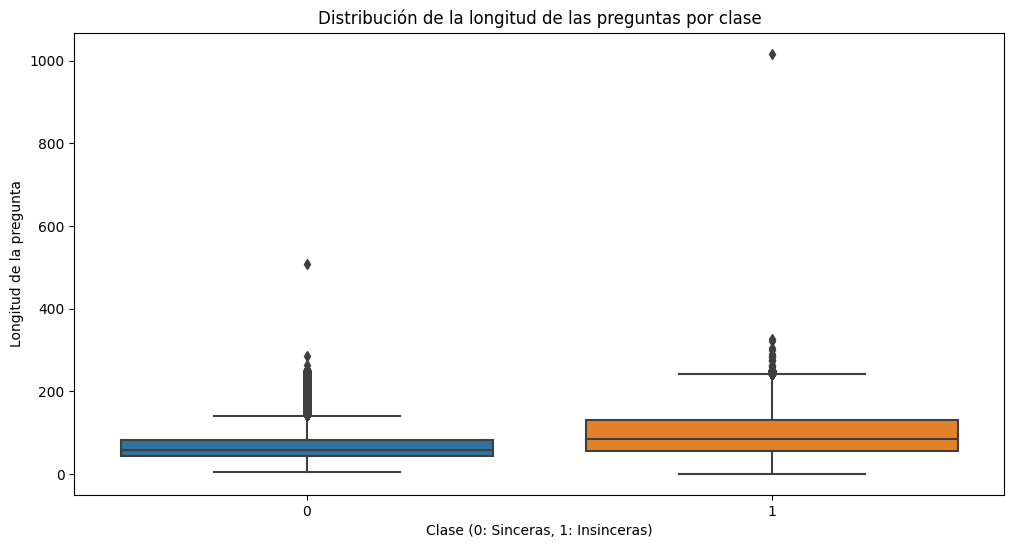

In [43]:
# 4. Boxplots para la longitud de las preguntas
plt.figure(figsize=(12, 6))
sns.boxplot(x='target', y='length', data=train)
plt.title('Distribución de la longitud de las preguntas por clase')
plt.xlabel('Clase (0: Sinceras, 1: Insinceras)')
plt.ylabel('Longitud de la pregunta')
plt.show()


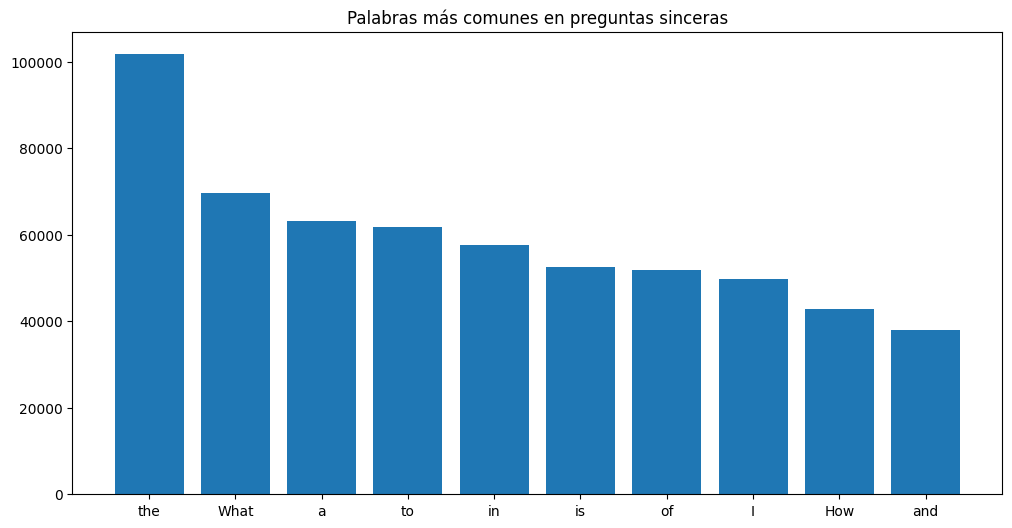

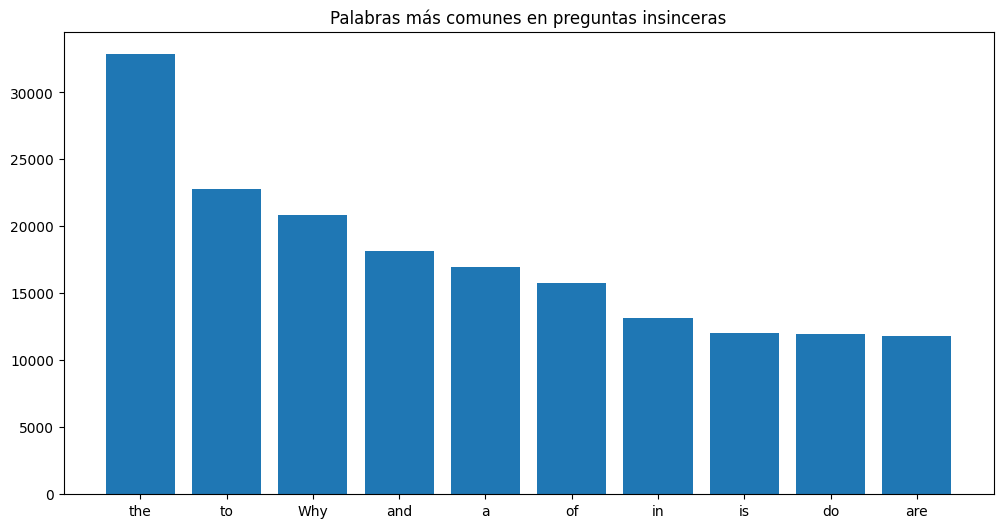

In [44]:
# 5. Palabras más comunes en preguntas sinceras vs insinceras
def plot_most_common_words(data, target_value, title=""):
    # Función para plotear las palabras más comunes
    words = ' '.join(data[data['target']==target_value]['question_text']).split()
    counter = Counter(words)
    most_common = counter.most_common(10)
    words, counts = zip(*most_common)
    plt.figure(figsize=(12, 6))
    # sns.barplot(x = words,y = counts)
    plt.bar(words, counts)

    plt.title(title)
    plt.show()

plot_most_common_words(train, 0, "Palabras más comunes en preguntas sinceras")
plot_most_common_words(train, 1, "Palabras más comunes en preguntas insinceras")

## Removiendo stop words
Voy a remover stop words y volver analizar el set de testing

In [61]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


# Descargar el conjunto de stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

# Función para eliminar stopwords de un texto
def remove_stopwords(text):
  tokens = word_tokenize(text.lower())  # Primero tokenizo, hago minusculas y despues borro stopwords
  return " ".join([word for word in str(text).split() if word not in stop_words])

# Aplicar la función al dataset
train['question_text'] = train['question_text'].apply(lambda x: remove_stopwords(x))
validation['question_text'] = validation['question_text'].apply(lambda x: remove_stopwords(x))
test['question_text'] = test['question_text'].apply(lambda x: remove_stopwords(x))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


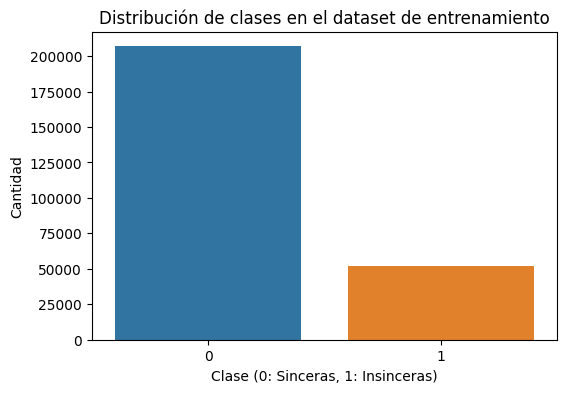

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

# 1. Distribución de clases
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=train)
plt.title('Distribución de clases en el dataset de entrenamiento')
plt.xlabel('Clase (0: Sinceras, 1: Insinceras)')
plt.ylabel('Cantidad')
plt.show()

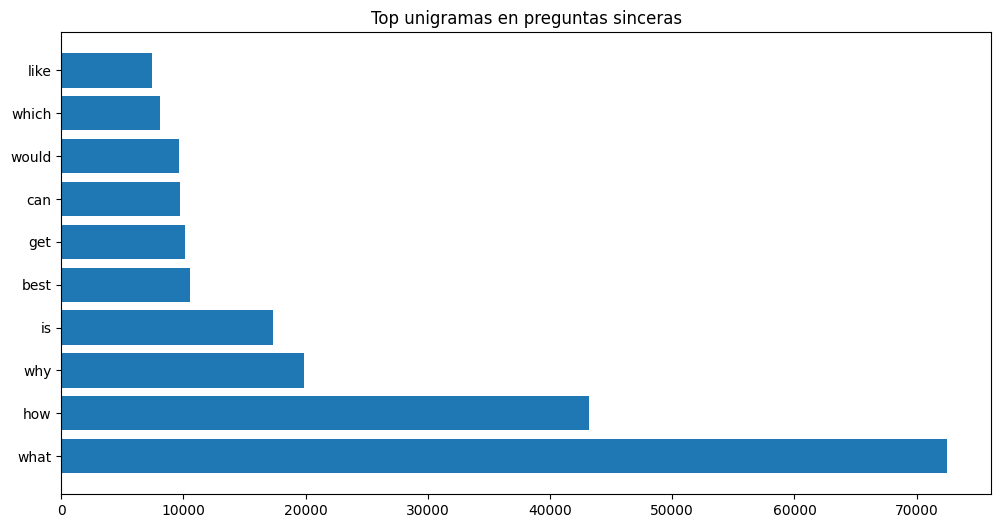

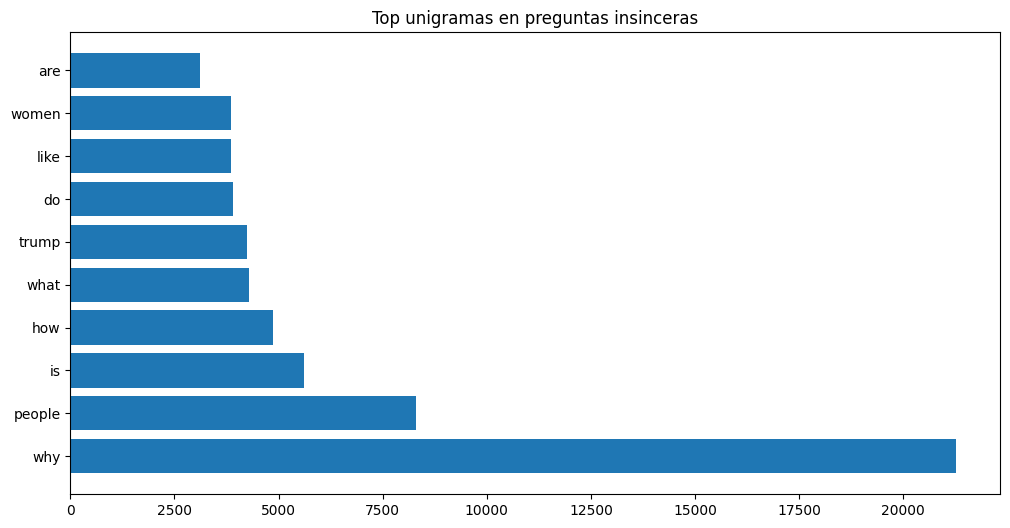

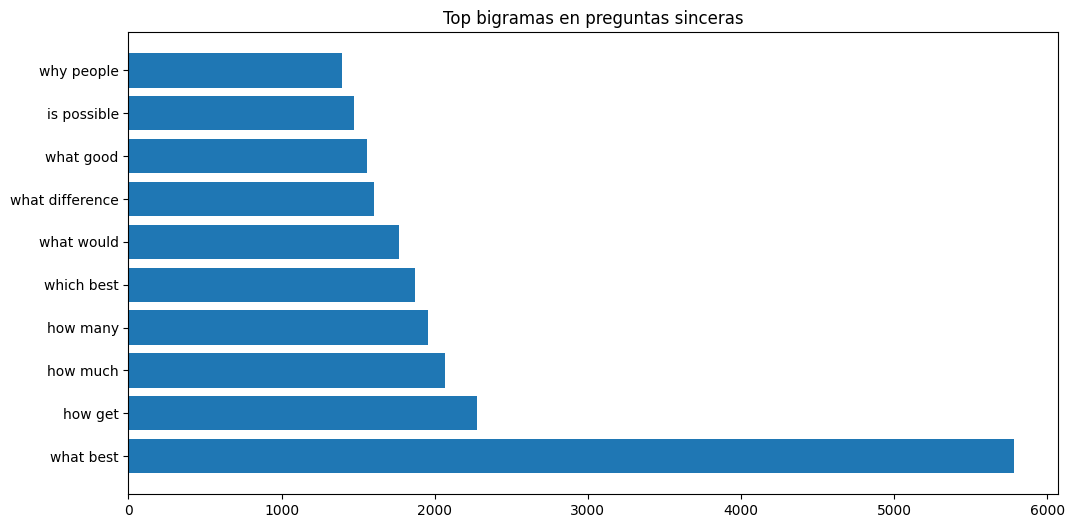

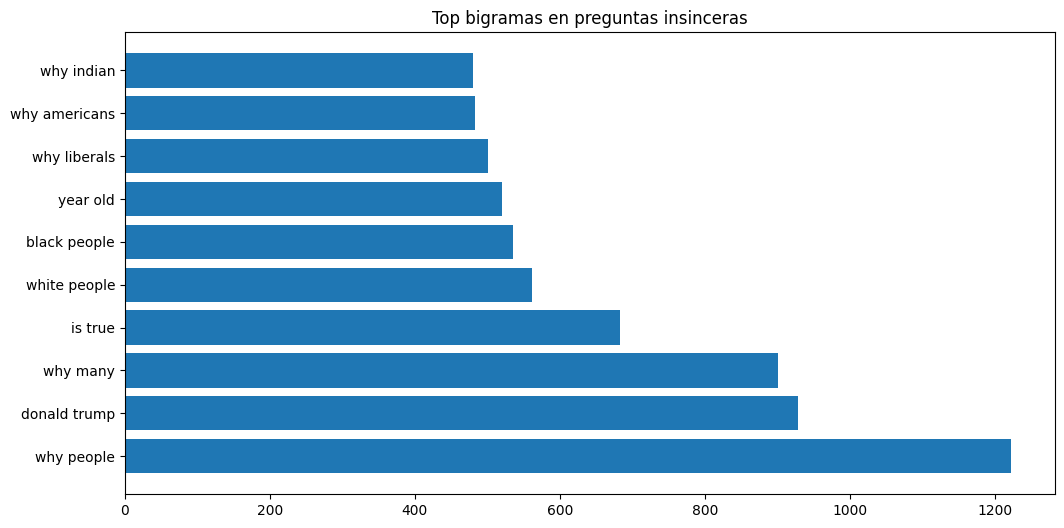

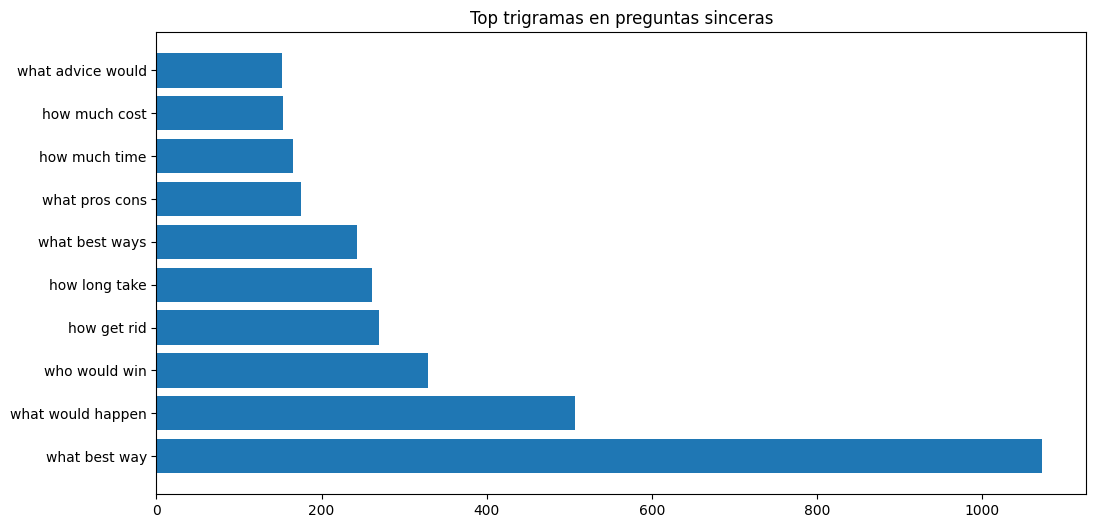

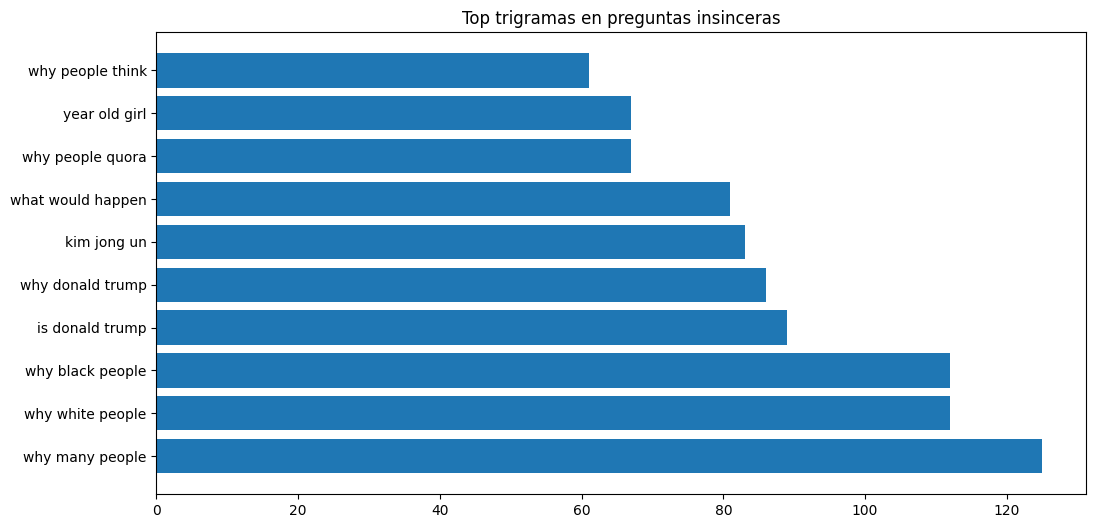

In [63]:
# 2. Análisis de n-gramas
def plot_top_ngrams(data, ngram_range=(1,1), top=10, title=""):
    # Función para plotear los n-gramas más comunes
    vec = CountVectorizer(ngram_range=ngram_range).fit(data)
    bag_of_words = vec.transform(data)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    words, values = zip(*words_freq[:top])
    plt.figure(figsize=(12, 6))
    plt.barh(words, values)
    plt.title(title)
    plt.show()

plot_top_ngrams(train[train['target']==0]['question_text'], (1,1), title="Top unigramas en preguntas sinceras")
plot_top_ngrams(train[train['target']==1]['question_text'], (1,1), title="Top unigramas en preguntas insinceras")
plot_top_ngrams(train[train['target']==0]['question_text'], (2,2), title="Top bigramas en preguntas sinceras")
plot_top_ngrams(train[train['target']==1]['question_text'], (2,2), title="Top bigramas en preguntas insinceras")
plot_top_ngrams(train[train['target']==0]['question_text'], (3,3), title="Top trigramas en preguntas sinceras")
plot_top_ngrams(train[train['target']==1]['question_text'], (3,3), title="Top trigramas en preguntas insinceras")

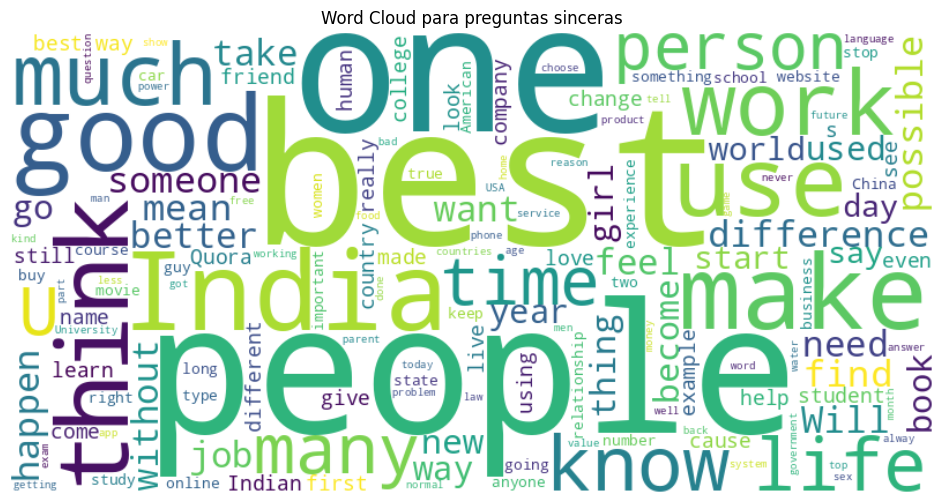

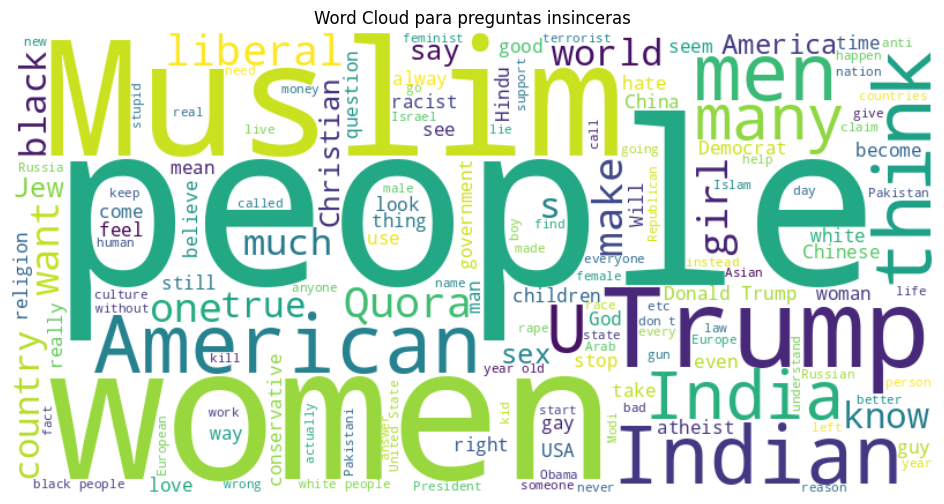

In [64]:
# 3. Word Clouds
def plot_wordcloud(data, title=""):
    # Función para plotear una nube de palabras
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=150).generate(" ".join(data))
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

plot_wordcloud(train[train['target']==0]['question_text'], "Word Cloud para preguntas sinceras")
plot_wordcloud(train[train['target']==1]['question_text'], "Word Cloud para preguntas insinceras")




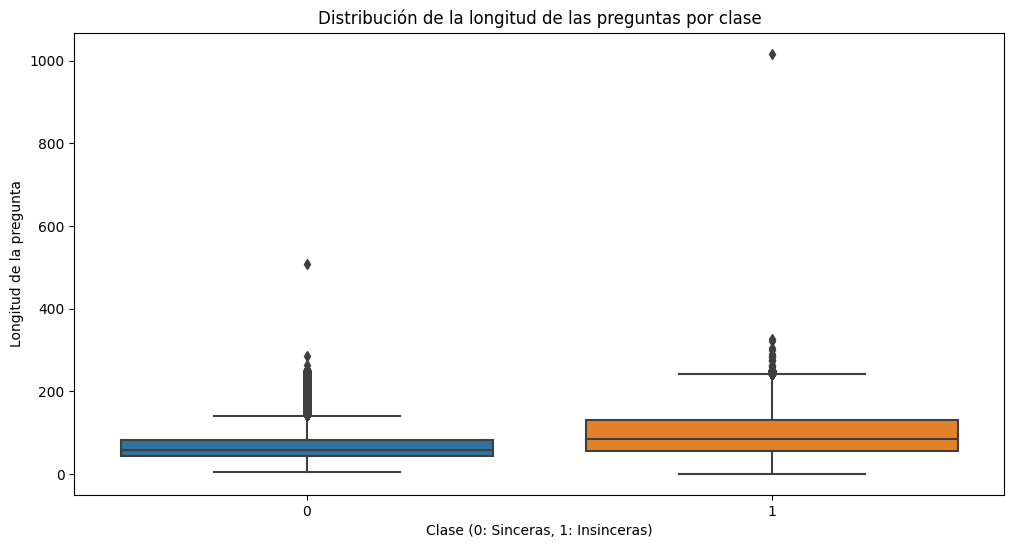

In [65]:
# 4. Boxplots para la longitud de las preguntas
plt.figure(figsize=(12, 6))
sns.boxplot(x='target', y='length', data=train)
plt.title('Distribución de la longitud de las preguntas por clase')
plt.xlabel('Clase (0: Sinceras, 1: Insinceras)')
plt.ylabel('Longitud de la pregunta')
plt.show()


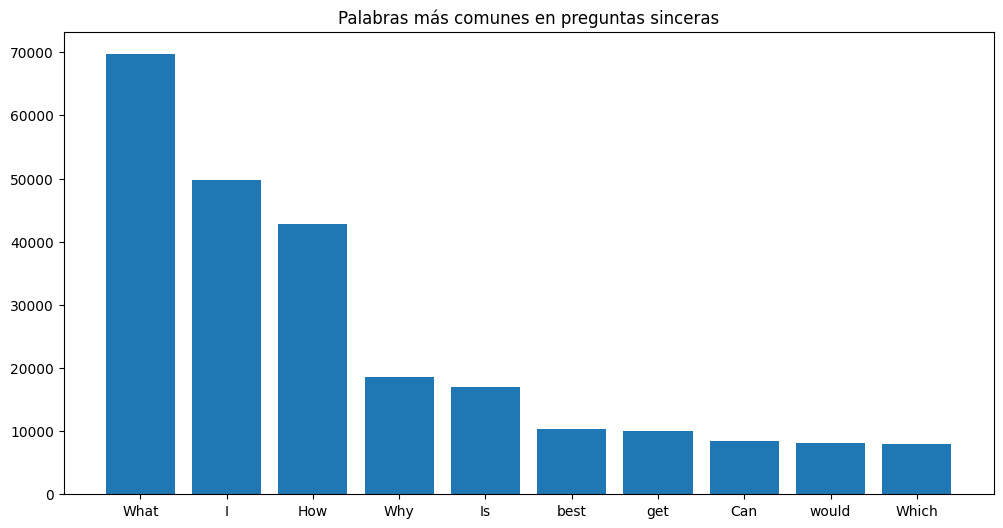

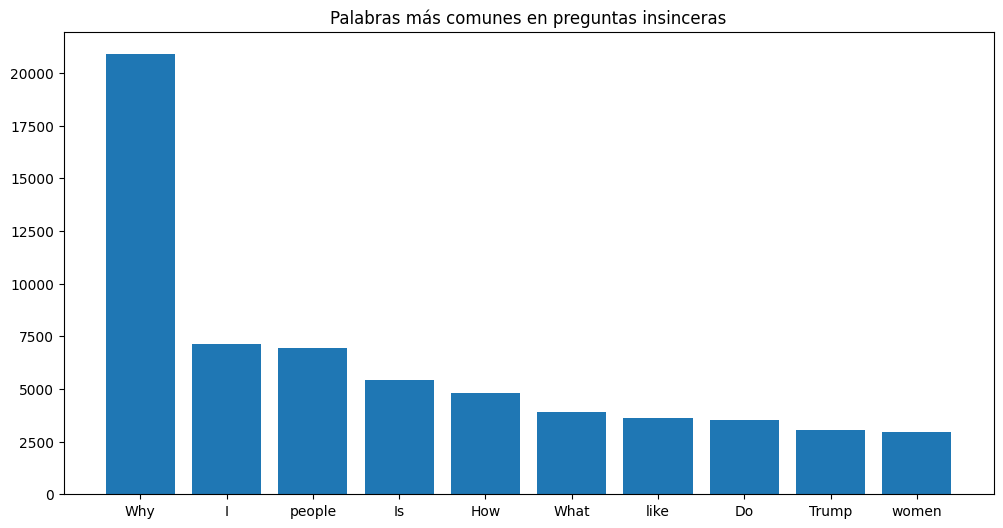

In [66]:
# 5. Palabras más comunes en preguntas sinceras vs insinceras
def plot_most_common_words(data, target_value, title=""):
    # Función para plotear las palabras más comunes
    words = ' '.join(data[data['target']==target_value]['question_text']).split()
    counter = Counter(words)
    most_common = counter.most_common(10)
    words, counts = zip(*most_common)
    plt.figure(figsize=(12, 6))
    # sns.barplot(x = words,y = counts)
    plt.bar(words, counts)

    plt.title(title)
    plt.show()

plot_most_common_words(train, 0, "Palabras más comunes en preguntas sinceras")
plot_most_common_words(train, 1, "Palabras más comunes en preguntas insinceras")

In [67]:
# Check if 'why' is a stopword
is_stopword = 'why' in stop_words
print(f"why es una stopword?: {is_stopword}")

why es una stopword?: True
